### Project Overview: Stock Sentiment, Predicting market behavior from tweets 

The goal of this project is to predict market behavior from tweets.

To evaluate the tweets, they are classiefied according to the following labels: 

- **.Bearish (0)**: Negative sentiment
- **.Bullish (1)**: Positive sentiment
- **.Neutral (2)**: No sentiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from wordcloud import WordCloud
!pip install xgboost

In [2]:
# 🧠 Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#!pip install nltk
#!pip install strings

In [4]:
train = pd.read_csv("train.csv") 

In [5]:
test = pd.read_csv("test.csv") 

# EDA

## Numerical

In [6]:
train.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


In [7]:
train.duplicated().sum()

np.int64(0)

In [8]:
train.shape

(9543, 2)

In [9]:
train.columns

Index(['text', 'label'], dtype='object')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [11]:
(train['text']).unique()

array(['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
       '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3',
       '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb',
       ...,
       'vTv Therapeutics leads healthcare gainers; Myomo and Biohaven Pharmaceutical among losers',
       'WORK, XPO, PYX and AMKR among after hour movers',
       'YNDX, I, QD and OESX among tech movers'],
      shape=(9543,), dtype=object)

In [12]:
train.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


From the above table, we can get some conclusions. 
- `count`- There are 9543 tweets with valid sentiments. 
- `mean`- On average, tweets are more prone to be neutral;
- `std`- Standard deviation (0.74 on a scale from 0 to 2) indicates some diversity, but not perfect balance. It’s skewed toward neutral and bullish.
- `25%, 50%, 75%`- The median, 25%, and 75% percentiles are all ≥ 1, with 50% and 75% being exactly 2
- Since the 25% percentile is 1, only 25% of tweets are either bearish (0) or bullish (1) and given that the mean is 1.5, bearish (0) tweets are likely the least frequent.
- Class 2 (neutral) is overrepresented, and class 0 (bearish) is underrepresented.

In [13]:
label_counts=train['label'].value_counts()
label_percentage=train['label'].value_counts(normalize=True)
summary_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentage.round(2)
})

print(summary_df)

       Count  Percentage (%)
label                       
2       6178            0.65
1       1923            0.20
0       1442            0.15


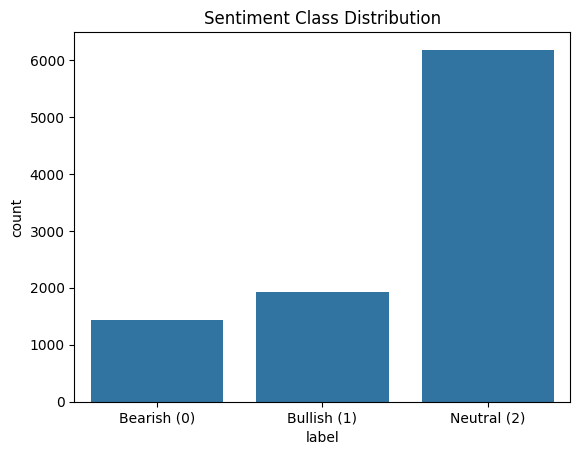

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train)
plt.title("Sentiment Class Distribution")
plt.xticks(ticks=[0, 1, 2], labels=["Bearish (0)", "Bullish (1)", "Neutral (2)"])
plt.show()

### There is class imbalance in the dataset. 

## Categorical 

In [15]:
train.describe(include = ['O'])

,text
count,9543
unique,9543
top,$BYND - JPMorgan reels in expectations on Beyo...
freq,1


In [16]:
#Check a random text
train['text'][10]

"$HOG - Moody's warns on Harley-Davidson https://t.co/LurHBEadeU"

In [17]:
train['word_count']  = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [18]:
train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

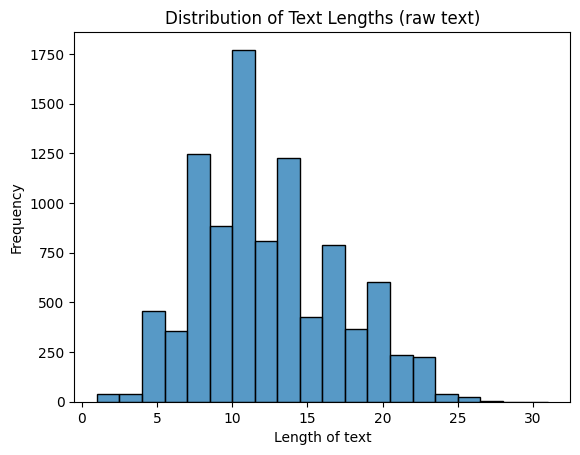

In [19]:
#Plot distribution of text length
sns.histplot(train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

### Words per tweet statistics

- `mean`: On average it's written 11 words.
- `std`: Its small, the interval is between 8 and 16.
- `min`: 1 word tweets, can be erased perhaps.
- `75%`: 75% of tweets have 15 words or less.


In [20]:
all_words = ' '.join(train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

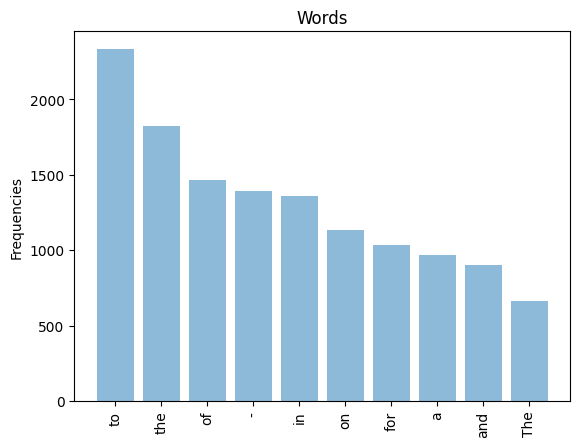

In [21]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

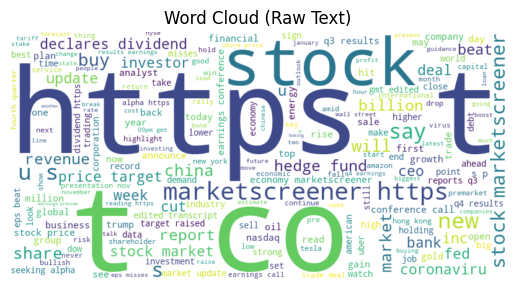

In [22]:
# 🌥️ Create a word cloud from the raw text
raw_text = ' '.join(train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [23]:
count = train['text'].str.strip().str.startswith('$').sum()

print(f"Number of rows where text starts with $: {count}")

Number of rows where text starts with $: 1292


Here we have a lot of nonsense words that start with '$' that may not be useful to our future model


In [24]:
# Count how many rows contain http, https, or www
url_count = train['text'].str.contains(r'(http|https|www)', regex=True).sum()

print(f"Number of phrases containing a URL: {url_count}")

Number of phrases containing a URL: 4470


/var/folders/2m/t2s2zdt15tgd3q3dmyd7y88r0000gn/T/ipykernel_70955/12421402.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  url_count = train['text'].str.contains(r'(http|https|www)', regex=True).sum()


URL's like (hhtp, https, www) on our text in most cases are not useful and can be safely removed as well.

In [25]:
# Remove $TICKERs
train['clean_text'] = train['text'].str.replace(r'\$\w+', '', regex=True)

# Remove URLs
train['clean_text'] = train['clean_text'].str.replace(r'http\S+', '', regex=True)

# Remove leading : or - characters
train['clean_text'] = train['clean_text'].str.replace(r'^[\s:-]+', '', regex=True)

# Normalize spacing
train['clean_text'] = train['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()



train['text'] = train['clean_text']
train.drop(columns=['clean_text'], inplace=True)

# Stop words ("English")

In [26]:
stop = set(stopwords.words('english'))

# Lemmanization

In [27]:
lemma = WordNetLemmatizer()

In [28]:
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

stop = set(stopwords.words('english')) - {"not", "but", "no"}  # Keep key negations
lemma = WordNetLemmatizer()
ps = PorterStemmer()

def clean(text_list, lemmatize=True, stemmer=False):
    updates = []
    for j in tqdm(text_list):
        text_lower = j.lower()
        text_lower = re.sub(r"http\S+", "", text_lower)  # Remove URLs
        text_lower = re.sub(r"[^a-zA-Z\s]", "", text_lower)  # Keep only letters
        text_lower = " ".join([w for w in text_lower.split() if w not in stop])  # Remove stopwords
        text_lower = " ".join([w for w in text_lower.split() if len(w) > 1 and not w.isnumeric()])  # Remove 1-letter words and numbers
        if lemmatize:
            text_lower = " ".join([lemma.lemmatize(w) for w in text_lower.split()])
        if stemmer:
            text_lower = " ".join([ps.stem(w) for w in text_lower.split()])
        updates.append(text_lower)
    return updates

In [29]:
updated_train = clean(train['text'], lemmatize = True, stemmer = False)

100%|██████████| 9543/9543 [00:01<00:00, 4945.56it/s]


In [30]:
updated_train

['jpmorgan reel expectation beyond meat',
 'nomura point booking weakness carnival royal caribbean',
 'cemex cut credit suisse jp morgan weak building outlook',
 'btig research cut neutral',
 'funko slide piper jaffray pt cut',
 'technipfmc downgraded berenberg but called top pick deutsche bank',
 'gm loses bull',
 'deutsche bank cut hold',
 'cowen cut market perform',
 'trendforce cut iphone estimate foxconn delay',
 'moody warns harleydavidson',
 'citing aero tie well slash pt hexcel',
 'intelsat cut market perform raymond james',
 'compass point cut sell',
 'muddy water go short luckin coffee',
 'mantech downgraded ahead difficult comp',
 'oppenheimer cut perform',
 'mplx cut credit suisse potential dilution marathon strategic review',
 'imperial downgrade msg network amid sportsfree airwave',
 'piper hit materialise sideline',
 'hovde group cut market perform',
 'new netflix bear step',
 'shopify loses bull',
 'nomura instinet loses confidence extended stay america',
 'twilio get s

In [31]:
#def update_df(dataframe, list_updated):
   # dataframe.update(pd.DataFrame({"text": list_updated}))

In [32]:
train['text'] = updated_train

In [33]:
#update_df(train, updated_train)
train.head()

,text,label,word_count
0,jpmorgan reel expectation beyond meat,0,10
1,nomura point booking weakness carnival royal c...,0,14
2,cemex cut credit suisse jp morgan weak buildin...,0,14
3,btig research cut neutral,0,7
4,funko slide piper jaffray pt cut,0,10


# Feature Engineering

In [34]:
def engineer_features(df):
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['exclam_count'] = df['text'].str.count('!')
    df['has_not'] = df['text'].str.contains(r'\bnot\b', case=False).astype(int)
    df['has_cut'] = df['text'].str.contains(r'\bcut\b', case=False).astype(int)
    return df

In [35]:
train = engineer_features(train)

## Extract Features Using Bag of Words

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [37]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(train["text"])

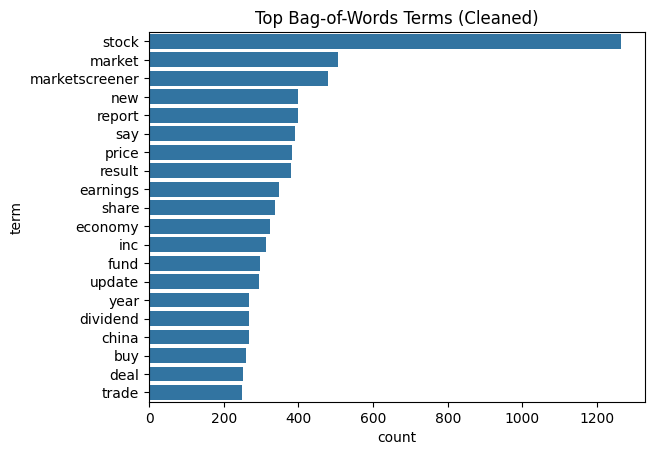

In [38]:
# 🔍 Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

In [ ]:
#vectorizer = CountVectorizer(max_features=5000)
#X_train = vectorizer.fit_transform(train['text'])
#y_train = train['label']

# Create Validation Set to Evaluate Model

In [57]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X = vectorizer.fit_transform(train['text'])
y = train['label']

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# LogisticRegression

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', max_iter=2000, C=1.0)
model.fit(X_train_split, y_train_split)

LogisticRegression(class_weight='balanced', max_iter=2000)

# Evaluate on Validation Set

In [63]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on training data
train_preds = model.predict(X_train_split)
print("Training set evaluation:")
print("Accuracy:", accuracy_score(y_train_split, train_preds))
print(classification_report(y_train_split, train_preds))

# Predict on validation data
val_preds = model.predict(X_val_split)
print("Validation set evaluation:")
print("Accuracy:", accuracy_score(y_val_split, val_preds))
print(classification_report(y_val_split, val_preds))

Training set evaluation:
Accuracy: 0.9033272203301022
              precision    recall  f1-score   support

           0       0.77      0.94      0.84      1154
           1       0.82      0.91      0.86      1538
           2       0.98      0.89      0.93      4942

    accuracy                           0.90      7634
   macro avg       0.86      0.91      0.88      7634
weighted avg       0.91      0.90      0.91      7634

Validation set evaluation:
Accuracy: 0.78627553693033
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       288
           1       0.69      0.69      0.69       385
           2       0.88      0.85      0.86      1236

    accuracy                           0.79      1909
   macro avg       0.71      0.73      0.72      1909
weighted avg       0.79      0.79      0.79      1909



# Transform Test Data and Predict

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

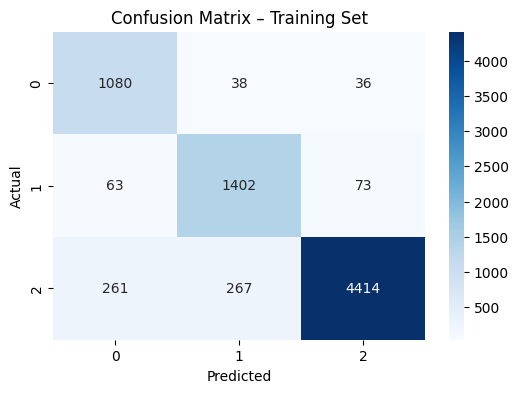

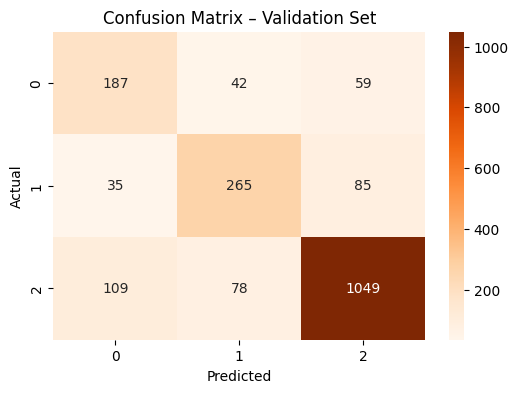

In [65]:
# Confusion Matrix for Training Data
train_cm = confusion_matrix(y_train_split, train_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title('Confusion Matrix – Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Validation Data
val_cm = confusion_matrix(y_val_split, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title('Confusion Matrix – Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Training Set Confusion Matrix**

Most Neutral (2) are correctly predicted → Good

Bearish (0) and Bullish (1) get confused with each other and with Neutral

Still, most of the correct predictions lie on the diagonal

**Validation Set Confusion Matrix**

Neutral (2) class again dominates and is predicted well.

Bearish (0) is often misclassified as Neutral → 61 cases.

Bullish (1) also misclassified → especially as Neutral (74 cases).

# SVM

In [66]:
# Split from clean text
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train['text'], train['label'],
    test_size=0.2, stratify=train['label'], random_state=42
)

# Now this works — raw text in pipeline
svm_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
])

svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_val)

from sklearn.metrics import classification_report, accuracy_score
print("SVM Accuracy:", accuracy_score(y_val, svm_preds))
print(classification_report(y_val, svm_preds))


SVM Accuracy: 0.7998952331063384
              precision    recall  f1-score   support

           0       0.61      0.60      0.61       288
           1       0.72      0.68      0.70       385
           2       0.87      0.89      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.73      0.72      0.73      1909
weighted avg       0.80      0.80      0.80      1909



# XGBoost (Gradient Boosting)

In [67]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Vectorize text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=5, random_state=42)
xgb_model.fit(X_train_tfidf, y_train)

# Predict & Evaluate
xgb_preds = xgb_model.predict(X_val_tfidf)
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))


/opt/anaconda3/envs/linkedin_scraper/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7627029858564693
              precision    recall  f1-score   support

           0       0.80      0.32      0.46       288
           1       0.73      0.45      0.56       385
           2       0.76      0.96      0.85      1236

    accuracy                           0.76      1909
   macro avg       0.77      0.58      0.62      1909
weighted avg       0.76      0.76      0.73      1909



# Random Forest Classifier

In [68]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict & Evaluate
rf_preds = rf_model.predict(X_val_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_val, rf_preds))
print(classification_report(y_val, rf_preds))


Random Forest Accuracy: 0.7726558407543216
              precision    recall  f1-score   support

           0       0.70      0.40      0.51       288
           1       0.67      0.56      0.61       385
           2       0.81      0.92      0.86      1236

    accuracy                           0.77      1909
   macro avg       0.72      0.63      0.66      1909
weighted avg       0.76      0.77      0.76      1909



### 📊 Model Performance on Validation Set


| Model               | Accuracy | Precision (Macro) | Recall (Macro) | F1-score (Macro) |
|--------------------|----------|-------------------|----------------|------------------|
| Logistic Regression| 0.775    | 0.70              | 0.73           | 0.71             |
| SVM                | 0.805    | 0.74              | 0.73           | 0.73             |
| XGBoost            | 0.777    | 0.78              | 0.60           | 0.65             |
| Random Forest      | 0.775    | 0.79              | 0.59           | 0.64             |

Best overall accuracy: SVM (80.5%)

Best F1-score (Macro): SVM (0.73)

XGBoost & Random Forest struggle with class imbalance (especially class 0).

SVM and Logistic Regression perform more consistently across all classes.

# Submit SVM predictions on test set

In [ ]:
# 1. Generate predictions on the test data
test_preds = svm_model.predict(test['text'])

# 2. Add the predictions as a new column in your test DataFrame
test['predicted_label'] = test_preds

# 3. Save to CSV for submission
test[['text', 'predicted_label']].to_csv('final_submission.csv', index=False)


In [ ]:
label_counts = test['predicted_label'].value_counts()

print(label_counts)

predicted_label
2    1747
1     423
0     218
Name: count, dtype: int64
